### Invoke Packages

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
%matplotlib inline

### Reading dataframe and clearning the noise

In [149]:
loans_2007 = pd.read_csv(r"./databank/loans_2007.csv", low_memory = False)

# Removing rows with duplicate data
loans_2007 = loans_2007.drop_duplicates()
# Display first row of  the dataframe
print(loans_2007.info())
# Display dataframe size
print("\nTotal number of features : ",  loans_2007.shape[1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42538 entries, 0 to 42537
Data columns (total 52 columns):
id                            42538 non-null object
member_id                     42535 non-null float64
loan_amnt                     42535 non-null float64
funded_amnt                   42535 non-null float64
funded_amnt_inv               42535 non-null float64
term                          42535 non-null object
int_rate                      42535 non-null object
installment                   42535 non-null float64
grade                         42535 non-null object
sub_grade                     42535 non-null object
emp_title                     39909 non-null object
emp_length                    41423 non-null object
home_ownership                42535 non-null object
annual_inc                    42531 non-null float64
verification_status           42535 non-null object
issue_d                       42535 non-null object
loan_status                   42535 non-null object
p

### Cleaning dataframe by columns carrying irrelevant information

In [150]:
cols = ["id", "member_id", "funded_amnt", "funded_amnt_inv", "grade", "sub_grade", "emp_title",  
        "issue_d", "zip_code", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", 
        "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", 
        "last_pymnt_d", "last_pymnt_amnt"]
loans_2007 = loans_2007.drop(cols, axis=1)
loans_2007.shape[1]

32

### Selecting Target Column  

In [151]:
# Selecting "loan_status" as a target column
loans_2007["loan_status"].value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

### Cleaning the target column

In [152]:
# Only first two values above in "Load_Status" are found to be useful for our modeling.
keep = ["Fully Paid", "Charged Off"]
map_dict = {"Fully Paid": 1, "Charged Off": 0}

loans_2007 = loans_2007[(loans_2007["loan_status"] == keep[0]) | (loans_2007["loan_status"] \
                                                                  == keep[1])]
loans_2007["loan_status"] = loans_2007["loan_status"].map(map_dict)
loans_2007["loan_status"].unique()

array([1, 0], dtype=int64)

### Removing the columns with single value

In [153]:
# Since single valued columns carry no useful information for credibility evaluation purpose.
drop_columns = []

for col in loans_2007.columns:
    current = loans_2007[col].dropna()
    if len(current.unique()) == 1:
        drop_columns.append(col)

loans_2007 = loans_2007.drop(drop_columns, axis=1)
loans_2007.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

### Checking the dataframe for null values

In [154]:
# Display list of columns carrying null values (in descending order)
null_counts = loans_2007.isnull().sum().sort_values(ascending=False)
null_counts[0:10]

emp_length              1036
pub_rec_bankruptcies     697
revol_util                50
title                     11
last_credit_pull_d         2
purpose                    0
term                       0
int_rate                   0
installment                0
home_ownership             0
dtype: int64

### Verifying the null values proportion 

In [155]:
# Show columns with number of null values as percentage of total training examples
# (in descending order) 
null_percent = (loans_2007.isnull().sum()/loans_2007.shape[0]).sort_values(ascending=False)*100
null_percent[0:5]

emp_length              2.672169
pub_rec_bankruptcies    1.797782
revol_util              0.128966
title                   0.028372
last_credit_pull_d      0.005159
dtype: float64

Consider clearning columns with more less 1% NULL value while removing the columns with above 1% NULL values.

### Further Cleaning/Removing the dataframe

In [156]:
loans_2007 = loans_2007.drop('pub_rec_bankruptcies', axis=1)
loans_2007 = loans_2007.dropna(subset=['title', 'revol_util', 'last_credit_pull_d'],  
                               axis=0, how='any')
print("Total NaN values in the dataframe: ", loans_2007.isnull().sum().sum())
print('pub_rec_bankruptcies' in loans_2007)

Total NaN values in the dataframe:  1032
False


### Review the columns that carry object type data

In [157]:
object_columns_df = loans_2007.select_dtypes(include=["object"])
object_columns_df.iloc[0]

term                     36 months
int_rate                    10.65%
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
revol_util                   83.7%
last_credit_pull_d        Jun-2016
Name: 0, dtype: object

The following columns seem to carry categorical data that could be helpful for our regression analysis later:

* term
* emp_length
* home_ownership
* verification_status
* purpose
* title

The above results show that the following columns carry type of information that we can convert into numerical type for further analysis:

* int_rate
* revol_util

The remaining table seem to be not much useful and should be drop for our data frame. They are: 

* addr_state
* earliest_cr_line
* last_credit_pull_d

### Verify the columns with categorical data 

In [158]:
cols = ['term', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'title']

for i in cols:
    print("\nUnique Counts for " + i + " :\n", object_columns_df[i].value_counts())


Unique Counts for term :
  36 months    29040
 60 months     9667
Name: term, dtype: int64

Unique Counts for emp_length :
 10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64

Unique Counts for home_ownership :
 RENT        18513
MORTGAGE    17111
OWN          2984
OTHER          96
NONE            3
Name: home_ownership, dtype: int64

Unique Counts for verification_status :
 Not Verified       16696
Verified           12289
Source Verified     9722
Name: verification_status, dtype: int64

Unique Counts for purpose :
 debt_consolidation    18130
credit_card            5039
other                  3864
home_improvement       2897
major_purchase         2154
small_business         1762
car                    1510
wedding                 929
medical                 680
moving                  576
vacation         

It appears that column 'purpose' and 'title' carry overlapping information. However, considering the duplication of loan categories under the 'title' column, let's keep the 'purpose' column and drop the 'title' one.

Column 'emp_length' carries multiple category data.

### Drop less useful columns with duplicate/overlapping data

In [159]:
cols = ['addr_state', 'earliest_cr_line', 'last_credit_pull_d', 'title']
loans_2007 = loans_2007.drop(cols, axis=1)

### Assign data variables to columns

In [160]:
cat_columns = ['home_ownership', 'verification_status', 'purpose', 'term']
loans_2007_dummies = pd.get_dummies(loans_2007[cat_columns])
loans_2007 = pd.concat([loans_2007, loans_2007_dummies], axis=1)

# Removinng the original non-dummy columns 
loans_2007 = loans_2007.drop(cat_columns, axis=1)
loans_2007.columns

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object')

### Mapping column with multiple category data

In [161]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        np.nan: 0
    }
}

loans_2007 = loans_2007.replace(mapping_dict)
np.sort(loans_2007['emp_length'].unique().astype('int64'))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

### Convert Columns String type Numeric Data to Real Numbers

In [162]:
loans_2007['int_rate'] = loans_2007['int_rate'].str.rstrip('%').astype('float')
loans_2007['revol_util'] = loans_2007['revol_util'].str.rstrip('%').astype('float')

### Preserving completely cleansed dataframe in .csv format

In [163]:
loans_2007.to_csv("cleaned_loans_2007.csv", index=False)
loans_2007.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38707 entries, 0 to 39785
Data columns (total 38 columns):
loan_amnt                              38707 non-null float64
int_rate                               38707 non-null float64
installment                            38707 non-null float64
emp_length                             38707 non-null int64
annual_inc                             38707 non-null float64
loan_status                            38707 non-null int64
dti                                    38707 non-null float64
delinq_2yrs                            38707 non-null float64
inq_last_6mths                         38707 non-null float64
open_acc                               38707 non-null float64
pub_rec                                38707 non-null float64
revol_bal                              38707 non-null float64
revol_util                             38707 non-null float64
total_acc                              38707 non-null float64
home_ownership_MORTGAGE    

### Finalizing the feature columns

In [164]:
features = loans_2007.columns.values

### Evaluating the data skewness

1    33092
0     5615
Name: loan_status, dtype: int64
The binary data ratio = 1 : 5.893499554764025


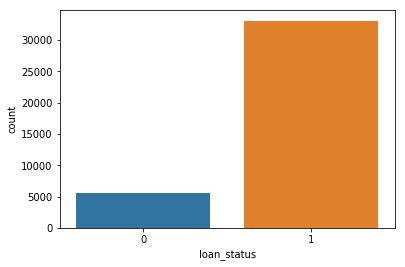

In [165]:
target_vals = loans_2007["loan_status"].value_counts()
print(target_vals)

print("The binary data ratio = 1 :", target_vals[1] / target_vals[0])
sns.countplot(x="loan_status", data=loans_2007)

### Develop Logistic Regression Model and Fit Verification

In [166]:
# split train/test/cv as 60/20/20
train_set = loans_2007.iloc[:23224]
test_set = loans_2007.iloc[23225:30966]
cross_val = loans_2007.iloc[30967:]

# Find the logistic regression model using sklearn
logistic_model = LogisticRegression()
logistic_model.fit(train_set[features], train_set["loan_status"])
predictions_test = logistic_model.predict(test_set[features])
mse_vals_test = mean_squared_error(predictions_test, test_set["loan_status"])

mse_vals_test

0.1331869267536494

### Verifying the Logistic Reg Model over CV Set

In [167]:
# Find the MSE for CV

logistic_model = LogisticRegression()
logistic_model.fit(train_set[features], train_set["loan_status"])
predictions_cv = logistic_model.predict(cross_val[features])
mse_vals_cv = mean_squared_error(predictions_cv, cross_val["loan_status"])

mse_vals_cv

0.13217054263565892

### Checking the Model Generalization using Another Classifier

In [168]:
# Check for model generalization using scikit-learn package and carry out K-Fold 
# Cross Validation

logistic_model = LogisticRegression()
predictions_tot = pd.Series(cross_val_predict(logistic_model, X=loans_2007[features], 
                                              y=loans_2007["loan_status"], cv=11))
mse_vals_tot = mean_squared_error(predictions_tot, loans_2007["loan_status"])

mse_vals_tot

0.14573591340067688

The error results for model predictibility over test set and cross-validation set using two different classifier. This shows a better model generalization for predictibility over outside data.

### Check Prediction Integrity using Evaluation Matrix

Precision over Test Set: 0.8683084899546338
Recall over Test Set: 0.9977658623771224
Accuracy over Test Set: 0.8668130732463506
FPR over Test Set: 0.9892891918208374
TPR over Test Set: 0.9977658623771224
F1 Score over Test Set: 0.9285466768313811
             precision    recall  f1-score   support

          0       0.42      0.01      0.02      1027
          1       0.87      1.00      0.93      6714

avg / total       0.81      0.87      0.81      7741



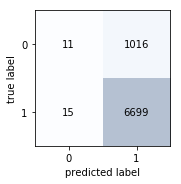

In [169]:
# Calc for TP/FP/TN/FN

# For Logistic Reg Classifier over Test Set

tp = len(predictions_test[(predictions_test == 1) & (test_set["loan_status"] == 1)])
tn = len(predictions_test[(predictions_test == 0) & (test_set["loan_status"] == 0)])
fp = len(predictions_test[(predictions_test == 1) & (test_set["loan_status"] == 0)])
fn = len(predictions_test[(predictions_test == 0) & (test_set["loan_status"] == 1)])

precision_test = tp / (tp + fp)
recall_test = tp / (tp + fn)
accuracy_test = (tp + tn) / len(test_set['loan_status'])
fpr_test = fp / (fp + tn)
tpr_test = tp / (tp + fn)
F1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)

print("Precision over Test Set:", precision_test)
print("Recall over Test Set:", recall_test)
print("Accuracy over Test Set:", accuracy_test)
print("FPR over Test Set:", fpr_test)
print("TPR over Test Set:", tpr_test)
print("F1 Score over Test Set:", F1_score_test)

# Verify the calc using sklearn function
plot_confusion_matrix(confusion_matrix(test_set["loan_status"], predictions_test))
print(classification_report(test_set['loan_status'], predictions_test))

Precision over Cross Validation Set: 0.8683563946721842
Recall over Cross Validation Set: 0.9992559523809523
Accuracy over Cross Validation Set: 0.8678294573643411
FPR over Cross Validation Set: 0.9980392156862745
TPR over Cross Validation Set: 0.9992559523809523
F1 Score over Cross Validation Set: 0.9292188472981389
             precision    recall  f1-score   support

          0       0.29      0.00      0.00      1020
          1       0.87      1.00      0.93      6720

avg / total       0.79      0.87      0.81      7740



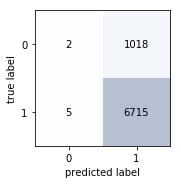

In [170]:
# Calc for TP/FP/TN/FN

# For Logistic Reg Classifier over Cross Validation Set

tp = len(predictions_cv[(predictions_cv == 1) & (cross_val["loan_status"] == 1)])
tn = len(predictions_cv[(predictions_cv == 0) & (cross_val["loan_status"] == 0)])
fp = len(predictions_cv[(predictions_cv == 1) & (cross_val["loan_status"] == 0)])
fn = len(predictions_cv[(predictions_cv == 0) & (cross_val["loan_status"] == 1)])

precision_cv = tp / (tp + fp)
recall_cv = tp / (tp + fn)
accuracy_cv = (tp + tn) / len(cross_val['loan_status'])
fpr_cv = fp / (fp + tn)
tpr_cv = tp / (tp + fn)
F1_score_cv = 2 * precision_cv * recall_cv / (precision_cv + recall_cv)

print("Precision over Cross Validation Set:", precision_cv)
print("Recall over Cross Validation Set:", recall_cv)
print("Accuracy over Cross Validation Set:", accuracy_cv)
print("FPR over Cross Validation Set:", fpr_cv)
print("TPR over Cross Validation Set:", tpr_cv)
print("F1 Score over Cross Validation Set:", F1_score_cv)

# Verify the calc using sklearn function
plot_confusion_matrix(confusion_matrix(cross_val["loan_status"], predictions_cv))
print(classification_report(cross_val['loan_status'], predictions_cv))

Precision by K-Fold Classify: 0.8556253660614451
Recall by K-Fold Classify: 0.9982295937383526
Accuracy by K-Fold Classify: 0.8306766217996745
FPR by K-Fold Classify: 0.9974250505793636
TPR by K-Fold Classify: 0.9982295937383526
F1 Score by K-Fold Classify: 0.9214427019123255
             precision    recall  f1-score   support

          0       0.32      0.00      0.01      5615
          1       0.86      1.00      0.92     33092

avg / total       0.78      0.85      0.79     38707



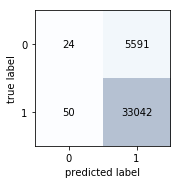

In [171]:
# Calc for TP/FP/TN/FN

# For K-Fold Cross Validation Classifier over entire data set

tp = len(predictions_tot[(predictions_tot == 1) & (loans_2007["loan_status"] == 1)])
tn = len(predictions_tot[(predictions_tot == 0) & (loans_2007["loan_status"] == 0)])
fp = len(predictions_tot[(predictions_tot == 1) & (loans_2007["loan_status"] == 0)])
fn = len(predictions_tot[(predictions_tot == 0) & (loans_2007["loan_status"] == 1)])

precision_tot = tp / (tp + fp)
recall_tot = tp / (tp + fn)
accuracy_tot = (tp + tn) / len(loans_2007['loan_status'])
fpr_tot = fp / (fp + tn)
tpr_tot = tp / (tp + fn)
F1_score_tot = 2 * precision_tot * recall_tot / (precision_tot + recall_tot)

print("Precision by K-Fold Classify:", precision_tot)
print("Recall by K-Fold Classify:", recall_tot)
print("Accuracy by K-Fold Classify:", accuracy_tot)
print("FPR by K-Fold Classify:", fpr_tot)
print("TPR by K-Fold Classify:", tpr_tot)
print("F1 Score by K-Fold Classify:", F1_score_tot)

# Verify the calc using sklearn function
plot_confusion_matrix(confusion_matrix(loans_2007["loan_status"], predictions_tot))
print(classification_report(loans_2007['loan_status'], predictions_tot))

### Results

In [172]:
output_cols = ["Test Set", "Cross Validation Set", "K-Fold Classify"]
output_index = ["precision", "recall", "accuracy", "fpr", "tpr", "F1_score", "MSE"]
output = pd.DataFrame(index = output_index, columns = output_cols)

output['Test Set'] = [precision_test, recall_test, accuracy_test, fpr_test, tpr_test, 
                      F1_score_test, mse_vals_test]
output['Cross Validation Set'] = [precision_cv, recall_cv, accuracy_cv, fpr_cv, tpr_cv, 
                                  F1_score_cv, mse_vals_cv]
output['K-Fold Classify'] = [precision_tot, recall_tot, accuracy_tot, fpr_tot, tpr_tot, 
                             F1_score_tot, mse_vals_tot]
output

,Test Set,Cross Validation Set,K-Fold Classify
precision,0.868308,0.868356,0.855625
recall,0.997766,0.999256,0.998230
accuracy,0.866813,0.867829,0.830677
fpr,0.989289,0.998039,0.997425
tpr,0.997766,0.999256,0.998230
F1_score,0.928547,0.929219,0.921443
MSE,0.133187,0.132171,0.145736


### Results Review

### Revise Model

In [173]:
# Need to reduce "False Positive" to improve predictive reliability
# To enhance conservative predictive outcome, let's set-up penalty for wrongly label "1"
penalty = {0:6, 1:1}
# Set up Logistic regression model
logistic_model = LogisticRegression(class_weight = penalty)
logistic_model.fit(train_set[features], train_set["loan_status"])
predictions_test_rev = logistic_model.predict(test_set[features])
mse_vals_test_rev = mean_squared_error(predictions_test_rev, test_set["loan_status"])

mse_vals_test_rev

0.0

### Re-verify the Logistic Reg Revised Model

In [174]:
# Find the MSE for CV

logistic_model.fit(train_set[features], train_set["loan_status"])
predictions_cv_rev = logistic_model.predict(cross_val[features])
mse_vals_cv_rev = mean_squared_error(predictions_cv_rev, cross_val["loan_status"])

mse_vals_cv_rev

0.0

### Re-Check (Manually) the Revised Model Generalization using Class Weights Classifier

Best parameters : {'class_weight': {0: 0.7605263157894736, 1: 0.2394736842105264}}
MSE for GridSearchCV Cross-Validation Check = 0.0


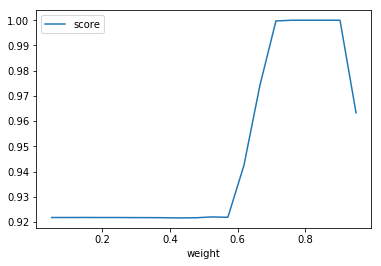

In [175]:
# Check for model generalization using scikit-learn GridSearchCV classifier 

wts = np.linspace(0.05, 0.95, 20)

# Initialize the classifier (presumming 3-Folds will provide a reasonable balance between
# the accuracy and computation time)
grdcv = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
                'class_weight': [{0: x, 1: 1.0-x} for x in wts]
                },
    scoring='f1',
    cv=3)

grd_rslt = grdcv.fit(loans_2007[features], loans_2007['loan_status'])
print("Best parameters : %s" % grd_rslt.best_params_)

# Plot the weights vs F1_score
df_wt = pd.DataFrame({ 'score': grd_rslt.cv_results_['mean_test_score'],
                       'weight': wts })
df_wt.plot(x='weight')

# Initializing the Logistic Regression Cross Validation
logistic_model_rev = LogisticRegression(**grd_rslt.best_params_)
logistic_model_rev.fit(train_set[features], train_set['loan_status'])
predictions_tot_rev = logistic_model_rev.predict(cross_val[features])
mse_vals_tot_rev = mean_squared_error(predictions_tot_rev, cross_val["loan_status"])

print("MSE for GridSearchCV Cross-Validation Check =", mse_vals_tot_rev)

### Re-Check Prediction Integrity using Evaluation Matrix

Precision over Test Set: 1.0
Recall over Test Set: 1.0
Accuracy over Test Set: 1.0
FPR over Test Set: 0.0
TPR over Test Set: 1.0
F1 Score over Test Set: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1027
          1       1.00      1.00      1.00      6714

avg / total       1.00      1.00      1.00      7741



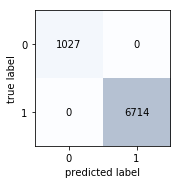

In [176]:
# Calc for TP/FP/TN/FN
# For Logistic Reg Classifier over Test Set

tp = len(predictions_test_rev[(predictions_test_rev == 1) & (test_set["loan_status"] == 1)])
tn = len(predictions_test_rev[(predictions_test_rev == 0) & (test_set["loan_status"] == 0)])
fp = len(predictions_test_rev[(predictions_test_rev == 1) & (test_set["loan_status"] == 0)])
fn = len(predictions_test_rev[(predictions_test_rev == 0) & (test_set["loan_status"] == 1)])

precision_test_rev = tp / (tp + fp)
recall_test_rev = tp / (tp + fn)
accuracy_test_rev = (tp + tn) / len(test_set['loan_status'])
fpr_test_rev = fp / (fp + tn)
tpr_test_rev = tp / (tp + fn)
F1_score_test_rev = 2 * precision_test_rev * recall_test_rev / (precision_test_rev + 
                                                                recall_test_rev)

print("Precision over Test Set:", precision_test_rev)
print("Recall over Test Set:", recall_test_rev)
print("Accuracy over Test Set:", accuracy_test_rev)
print("FPR over Test Set:", fpr_test_rev)
print("TPR over Test Set:", tpr_test_rev)
print("F1 Score over Test Set:", F1_score_test_rev)

# Verify the calc using sklearn function
plot_confusion_matrix(confusion_matrix(test_set["loan_status"], predictions_test_rev))
print(classification_report(test_set['loan_status'], predictions_test_rev))

Precision over Cross Validation Set: 1.0
Recall over Cross Validation Set: 1.0
Accuracy over Cross Validation Set: 1.0
FPR over Cross Validation Set: 0.0
TPR over Cross Validation Set: 1.0
F1 Score over Cross Validation Set: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1020
          1       1.00      1.00      1.00      6720

avg / total       1.00      1.00      1.00      7740



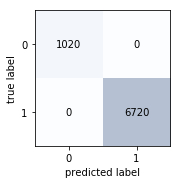

In [177]:
# Calc for TP/FP/TN/FN
# For Logistic Reg Classifier over Cross Validation Set

tp = len(predictions_cv_rev[(predictions_cv_rev == 1) & (cross_val["loan_status"] == 1)])
tn = len(predictions_cv_rev[(predictions_cv_rev == 0) & (cross_val["loan_status"] == 0)])
fp = len(predictions_cv_rev[(predictions_cv_rev == 1) & (cross_val["loan_status"] == 0)])
fn = len(predictions_cv_rev[(predictions_cv_rev == 0) & (cross_val["loan_status"] == 1)])

precision_cv_rev = tp / (tp + fp)
recall_cv_rev = tp / (tp + fn)
accuracy_cv_rev = (tp + tn) / len(cross_val['loan_status'])
fpr_cv_rev = fp / (fp + tn)
tpr_cv_rev = tp / (tp + fn)
F1_score_cv_rev = 2 * precision_cv_rev * recall_cv_rev / (precision_cv_rev + recall_cv_rev)

print("Precision over Cross Validation Set:", precision_cv_rev)
print("Recall over Cross Validation Set:", recall_cv_rev)
print("Accuracy over Cross Validation Set:", accuracy_cv_rev)
print("FPR over Cross Validation Set:", fpr_cv_rev)
print("TPR over Cross Validation Set:", tpr_cv_rev)
print("F1 Score over Cross Validation Set:", F1_score_cv_rev)

# Verify the calc using sklearn function
plot_confusion_matrix(confusion_matrix(cross_val["loan_status"], predictions_cv_rev))
print(classification_report(cross_val['loan_status'], predictions_cv_rev))

Precision by GridSearchCV Classifier: 1.0
Recall by GridSearchCV Classifier: 1.0
Accuracy by GridSearchCVClassifier: 1.0
FPR by GridSearchCV Classifier: 0.0
TPR by GridSearchCV Classifier: 1.0
F1 Score by GridSearchCV Classifier: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1020
          1       1.00      1.00      1.00      6720

avg / total       1.00      1.00      1.00      7740



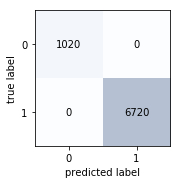

In [178]:
# Calc for TP/FP/TN/FN
# For GridSearchCV Classifier with Logistic Reg over the cross validation data set

tp = len(predictions_tot_rev[(predictions_tot_rev == 1) & (cross_val["loan_status"] == 1)])
tn = len(predictions_tot_rev[(predictions_tot_rev == 0) & (cross_val["loan_status"] == 0)])
fp = len(predictions_tot_rev[(predictions_tot_rev == 1) & (cross_val["loan_status"] == 0)])
fn = len(predictions_tot_rev[(predictions_tot_rev == 0) & (cross_val["loan_status"] == 1)])

precision_tot_rev = tp / (tp + fp)
recall_tot_rev = tp / (tp + fn)
accuracy_tot_rev = (tp + tn) / len(cross_val['loan_status'])
fpr_tot_rev = fp / (fp + tn)
tpr_tot_rev = tp / (tp + fn)
F1_score_tot_rev = 2 * precision_tot_rev * recall_tot_rev / (precision_tot_rev + 
                                                             recall_tot_rev)

print("Precision by GridSearchCV Classifier:", precision_tot_rev)
print("Recall by GridSearchCV Classifier:", recall_tot_rev)
print("Accuracy by GridSearchCVClassifier:", accuracy_tot_rev)
print("FPR by GridSearchCV Classifier:", fpr_tot_rev)
print("TPR by GridSearchCV Classifier:", tpr_tot_rev)
print("F1 Score by GridSearchCV Classifier:", F1_score_tot_rev)

# Verify the calc using sklearn function
plot_confusion_matrix(confusion_matrix(cross_val["loan_status"], predictions_tot_rev))
print(classification_report(cross_val['loan_status'], predictions_tot_rev))

### Revised Model Results Summary

In [179]:
output_cols = ["Test Set", "Cross Validation Set", "GridSearch CV"]
output_rev = pd.DataFrame(index = output_index, columns = output_cols)

output_rev['Test Set'] = [precision_test_rev, recall_test_rev, accuracy_test_rev, fpr_test_rev, 
                          tpr_test_rev, F1_score_test_rev, mse_vals_test_rev]
output_rev['Cross Validation Set'] = [precision_cv_rev, recall_cv_rev, accuracy_cv_rev, fpr_cv_rev, 
                                      tpr_cv_rev, F1_score_cv_rev, mse_vals_cv_rev]
output_rev["GridSearch CV"] = [precision_tot_rev, recall_tot_rev, accuracy_tot_rev, fpr_tot_rev, 
                               tpr_tot_rev, F1_score_tot_rev, mse_vals_tot_rev]
output_rev

,Test Set,Cross Validation Set,GridSearch CV
precision,1.0,1.0,1.0
recall,1.0,1.0,1.0
accuracy,1.0,1.0,1.0
fpr,0.0,0.0,0.0
tpr,1.0,1.0,1.0
F1_score,1.0,1.0,1.0
MSE,0.0,0.0,0.0


### Conclusion